# 1. Setup & Imports


In [ ]:
# Mount Google Drive to save model/log files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Essential data and model libraries
import pandas as pd  # For logging training metrics
from sklearn.model_selection import train_test_split  # For potential dataset splits
import torch  # PyTorch main lib
from torchvision.datasets import MNIST  # Built-in MNIST dataset
from torch.utils.data import Dataset, DataLoader, random_split  # Dataset utilities
from torchvision import transforms  # For image preprocessing
import torch.nn as nn  # For defining neural nets
import torch.optim as optim  # Optimizers
import matplotlib.pyplot as plt  # For plotting images and metrics
from torchsummary import summary  # Get model summary like in Keras
import copy  # For deep copying model weights
import os  # File and directory operations
import warnings  # Suppress annoying warnings
from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics
import seaborn as sns  # Pretty plots
import numpy as np  # Array ops

# Set warning filter to ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Set random seed so results are reproducible
torch.manual_seed(42)

In [ ]:
# Detect if GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# 2. Dataset & Transforms

In [ ]:
# Define image transform: convert to tensor and normalize to [-1, 1]
custom_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# Download MNIST training and testing datasets
train_dataset = MNIST(root='./data', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=custom_transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.08MB/s]


In [ ]:
# Split train into train + validation
train_dataset, val_dataset = random_split(train_dataset, [55000, 5000])

In [ ]:
# Print dataset sizes
print(f"Train Dataset contains {len(train_dataset)} samples.")
print(f"Validation Dataset contains {len(val_dataset)} samples.")
print(f"Test Dataset contains {len(test_dataset)} samples.")

# Check the shape of one image (should be 1x28x28)
image, _ = train_dataset[0]
print(f"Each image has shape: {image.shape}")

Train Dataset contains 55000 samples.
Validation Dataset contains 5000 samples.
Test Dataset contains 10000 samples.
Each image has shape: torch.Size([1, 28, 28])


# 3. Visualize Samples

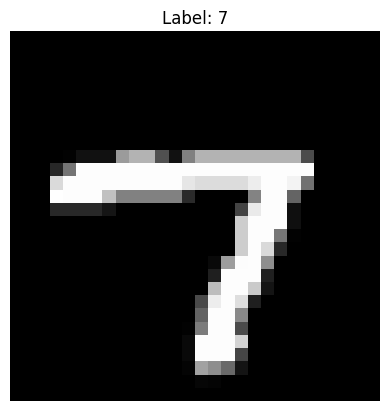

In [ ]:
# Pick an image from the dataset
img_tensor, label = train_dataset[10]

# Remove the channel dim (1x28x28 → 28x28) to plot
plt.imshow(img_tensor.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


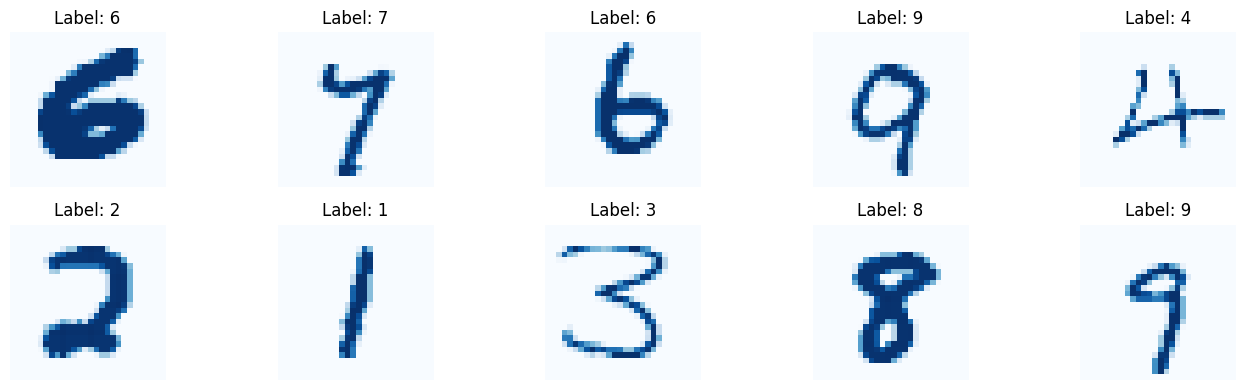

In [ ]:
# Show 10 sample images from training set
fig, axes = plt.subplots(2, 5, figsize=(14, 4))

for i in range(10):
    img, label = train_dataset[i]
    ax = axes[i // 5, i % 5]
    ax.imshow(img.squeeze(), cmap='Blues')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


# 4. DataLoaders

In [ ]:
# Wrap datasets in DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)


In [ ]:
# Print one batch’s shapes to verify
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break  # Only print the first batch

Batch of images shape: torch.Size([32, 1, 28, 28])
Batch of labels shape: torch.Size([32])


# 5. CNN Model Definition

In [ ]:
# Define a custom CNN
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        # Feature extractor (conv layers)
        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)  # 10 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# 6. Loss, Optimizer, Summary

In [ ]:
# Initialize model
custom_cnn = MyNN(1).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=0.01, weight_decay=1e-4)



In [ ]:
# Print model summary
summary(custom_cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
              ReLU-6           [-1, 64, 14, 14]               0
       BatchNorm2d-7           [-1, 64, 14, 14]             128
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 128]         401,536
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8,256
             ReLU-14                   

# 7. Training & Validation Utilities

In [ ]:
# Accuracy calculator
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


In [ ]:
# One epoch of training
def train_step(model, train_loader, criterion, optimizer, device):
    model.train()
    total_train_loss = 0
    total_train_acc = 0

    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += compute_accuracy(outputs, batch_labels)

    return total_train_loss / len(train_loader), total_train_acc / len(train_loader)

In [ ]:
# One epoch of validation
def validation_step(model, val_loader, criterion, device):
    model.eval()
    total_val_loss = 0
    total_val_acc = 0

    with torch.no_grad():
        for val_features, val_labels in val_loader:
            val_features, val_labels = val_features.to(device), val_labels.to(device)

            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)

            total_val_loss += val_loss.item()
            total_val_acc += compute_accuracy(val_outputs, val_labels)

    return total_val_loss / len(val_loader), total_val_acc / len(val_loader)

In [ ]:
def save_checkpoint(model, val_loss, best_val_loss, best_model, path='/content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/custom_cnn.pt'):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)  # Save the full model (architecture + weights)
        torch.save(best_model, path)  # Save the entire model
        print(f"✅ Best model saved at {path}")
    return best_val_loss, best_model


In [ ]:
# Log metrics to a DataFrame
def log_metrics(log_df, epoch, train_loss, train_acc, val_loss, val_acc):
    new_row = pd.DataFrame({
        'Epoch': [epoch + 1],
        'Train Loss': [train_loss],
        'Train Acc': [train_acc],
        'Val Loss': [val_loss],
        'Val Acc': [val_acc]
    })
    return pd.concat([log_df, new_row], ignore_index=True)

In [ ]:
# Early stopping logic
def early_stopping_check(epochs_no_improve, patience, val_loss, best_val_loss):
    if val_loss >= best_val_loss:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epoch(s)")
    else:
        epochs_no_improve = 0

    if epochs_no_improve >= patience:
        print("⏹ Early stopping triggered.")
        return True, epochs_no_improve
    return False, epochs_no_improve

In [ ]:
# Set training params and initialize stuff
epochs = 100
log_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(custom_cnn.state_dict())
best_model = None
epochs_no_improve = 0
patience = 5

# 8. Training Loop


In [ ]:
for epoch in range(epochs):
    # Training step
    custom_cnn.train()  # Ensure the custom_cnn is in training mode
    train_loss, train_acc = train_step(custom_cnn, train_loader, criterion, optimizer, device)

    # Validation step
    custom_cnn.eval()  # Set the custom_cnn to evaluation mode for validation
    val_loss, val_acc = validation_step(custom_cnn, val_loader, criterion, device)

    # Log metrics to CSV
    log_df = log_metrics(log_df, epoch, train_loss, train_acc, val_loss, val_acc)

    # Early stopping check (use best_val_loss *before* it’s updated)
    early_stop, epochs_no_improve = early_stopping_check(epochs_no_improve, patience, val_loss, best_val_loss)

    # Then update best_val_loss if it's really better
    best_val_loss, best_model = save_checkpoint(custom_cnn, val_loss, best_val_loss, best_model)

    if early_stop:
        break

    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


# Save the custom_cnn weights from the best epoch
custom_cnn = best_model  # This will be the custom_cnn with the best validation loss

# Save the training log
log_path = '/content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Logs/custom_cnn_training_log.csv'
os.makedirs(os.path.dirname(log_path), exist_ok=True)
log_df.to_csv(log_path, index=False)
print(f"📄 Training log saved at {log_path}")


✅ Best model saved at /content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/custom_cnn.pt
Epoch [1/100], Train Loss: 0.4947, Train Acc: 0.8610, Val Loss: 0.2412, Val Acc: 0.9530
✅ Best model saved at /content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/custom_cnn.pt
Epoch [2/100], Train Loss: 0.3196, Train Acc: 0.9193, Val Loss: 0.1192, Val Acc: 0.9678
⚠️ No improvement for 1 epoch(s)
Epoch [3/100], Train Loss: 0.2994, Train Acc: 0.9253, Val Loss: 0.2547, Val Acc: 0.9421
⚠️ No improvement for 2 epoch(s)
Epoch [4/100], Train Loss: 0.3155, Train Acc: 0.9240, Val Loss: 0.1789, Val Acc: 0.9578
✅ Best model saved at /content/drive/MyDrive/Pytorch_projects/MNIST_Digit_Classifier/Model/custom_cnn.pt
Epoch [5/100], Train Loss: 0.2857, Train Acc: 0.9280, Val Loss: 0.0989, Val Acc: 0.9753
⚠️ No improvement for 1 epoch(s)
Epoch [6/100], Train Loss: 0.3042, Train Acc: 0.9272, Val Loss: 0.1232, Val Acc: 0.9664
⚠️ No improvement for 2 epoch(s)
Epoch [7/100], Train Loss

# 9. Plot Training Metrics

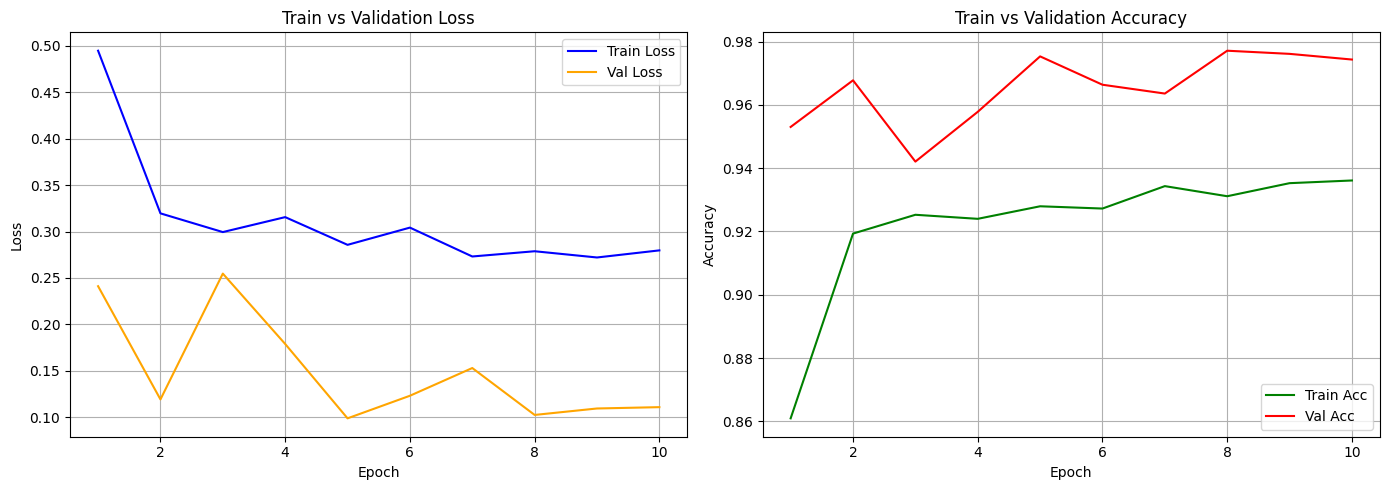

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Val Loss
axs[0].plot(log_df['Epoch'], log_df['Train Loss'], label='Train Loss', color='blue')
axs[0].plot(log_df['Epoch'], log_df['Val Loss'], label='Val Loss', color='orange')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train vs Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Train vs Val Accuracy
axs[1].plot(log_df['Epoch'], log_df['Train Acc'], label='Train Acc', color='green')
axs[1].plot(log_df['Epoch'], log_df['Val Acc'], label='Val Acc', color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Train vs Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# 10. Evaluate on Test Set

In [ ]:
all_preds = []
all_labels = []

custom_cnn.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = custom_cnn(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


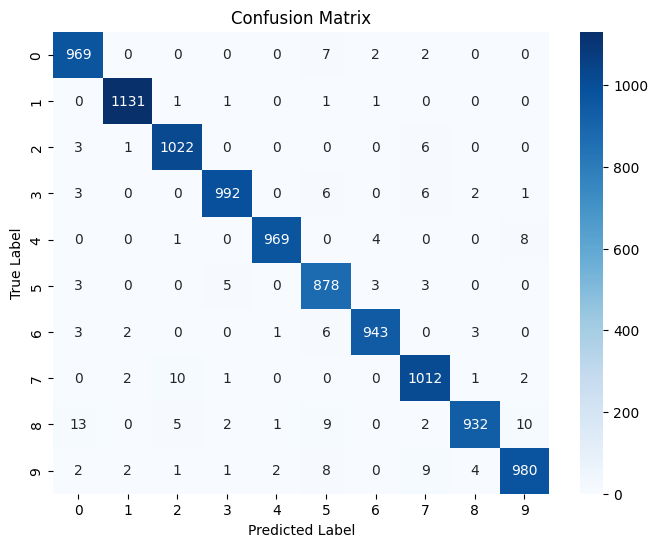

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0     0.9729    0.9888    0.9808       980
           1     0.9938    0.9965    0.9952      1135
           2     0.9827    0.9903    0.9865      1032
           3     0.9900    0.9822    0.9861      1010
           4     0.9959    0.9868    0.9913       982
           5     0.9596    0.9843    0.9718       892
           6     0.9895    0.9843    0.9869       958
           7     0.9731    0.9844    0.9787      1028
           8     0.9894    0.9569    0.9729       974
           9     0.9790    0.9713    0.9751      1009

    accuracy                         0.9828     10000
   macro avg     0.9826    0.9826    0.9825     10000
weighted avg     0.9829    0.9828    0.9828     10000

